In [ ]:
!pip install segment-anything opencv-python pycocotools matplotlib onnxruntime onnx ipywidgets ipyevents

In [22]:
import tifffile as tiff
import matplotlib.pyplot as plt
from ipywidgets import Image, VBox
from ipyevents import Event
import numpy as np
from io import BytesIO
from PIL import Image as PILImage
import time
import cv2
from segment_anything import sam_model_registry, SamPredictor

In [3]:
def load_tiff_file(file_path):
    images = tiff.imread(file_path)
    return images

def select_and_show_image(images):
    n = len(images)
    index = int(input(f"Enter image index (1 to {n}): ")) - 1
    if 0 <= index < n:
        plt.imshow(images[index], cmap='gray')
        plt.title(f'Image index: {index + 1}')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.axis('on')
        plt.show()
        time.sleep(3)
        return index
    else:
        print("Invalid index.")
        return None


In [4]:
def get_manual_coordinates(index):
    x = int(input("Enter x coordinate: "))
    y = int(input("Enter y coordinate: "))
    coords = {'image_index': index + 1, 'x': x, 'y': y}
    return coords

In [5]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

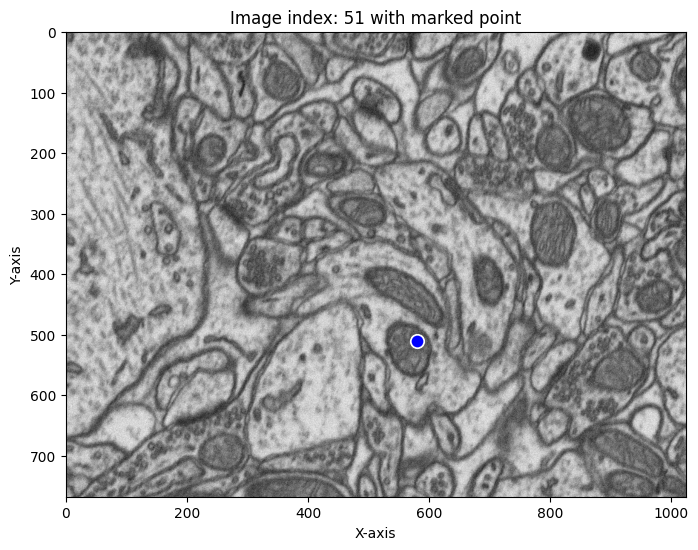

In [11]:
file_path = "/content/drive/MyDrive/Mitochondria-Data/Data/train/training.tif"
images = load_tiff_file(file_path)

# index = select_and_show_image(images)
index = 50
if index is not None:
    # coordinates = get_manual_coordinates(index)
    coords = {'image_index': index , 'x': 580, 'y': 510}
    input_point = np.array([[coordinates['x'], coordinates['y']]])
    input_label = np.array([1])
    the_img = images[index]
    plt.figure(figsize=(8, 8))
    plt.imshow(the_img, cmap='gray')
    show_points(input_point, input_label, plt.gca())
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(f"Image index: {index + 1} with marked point")
    plt.axis('on')
    plt.show()

In [19]:
the_img = cv2.cvtColor(the_img, cv2.COLOR_BGR2RGB)

In [20]:
sam_checkpoint = '/content/drive/MyDrive/Mitochondria-Data/sam-predictor/sam_vit_h_4b8939.pth'
device = 'cuda'
model_type = 'default'

In [23]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

sam.to(device=device)
predictor = SamPredictor(sam)

predictor.set_image(the_img)


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [24]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True)

In [25]:
masks.shape  # Number of masks, H, W

(3, 768, 1024)

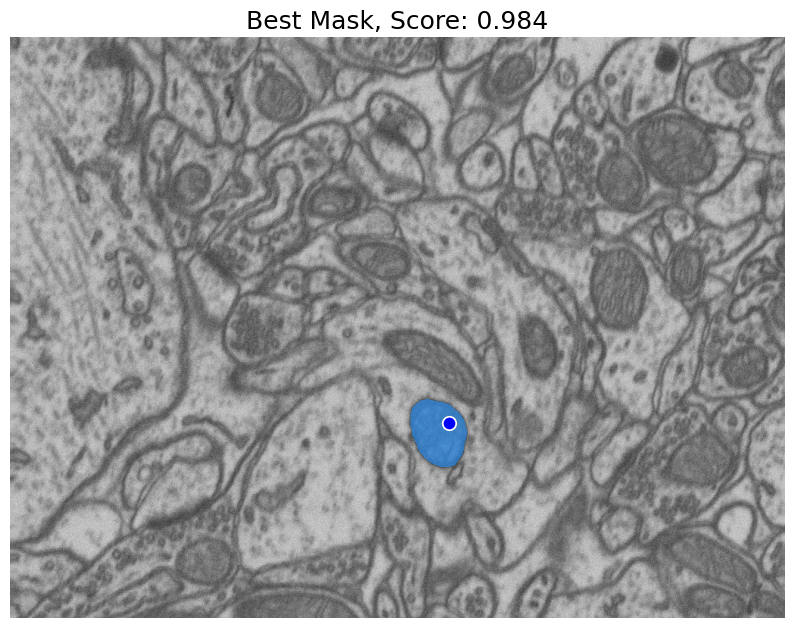

In [28]:
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(the_img)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()

best_index = np.argmax(scores)

plt.figure(figsize=(10, 10))
plt.imshow(the_img)
show_mask(masks[best_index], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Best Mask, Score: {scores[best_index]:.3f}", fontsize=18)
plt.axis('off')
plt.show()
